<a href="https://colab.research.google.com/github/Ahmad162539/Catalyst/blob/main/CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import re
from google.colab import files

def load_cv_data():
    # Use Colab's file upload functionality
    print("Please upload your Excel files.")
    uploaded = files.upload()  # This prompts the user to upload files

    # Ask if the user wants to normalize to weight
    normalize_choice = input("Do you want to normalize to weight? (y=yes, n=no): ").lower()

    # Load the uploaded files into a dictionary
    df_dict = {}
    for file_name in uploaded.keys():
        try:
            # Read the Excel file, assuming headers are in the first row
            data = pd.read_excel(file_name, header=0)

            # Identify columns based on headers
            voltage_col = data.columns.get_loc("Potential applied (V)")
            current_col = data.columns.get_loc("WE(1).Current (A)")
            scan_col = data.columns.get_loc("Scan")

            # Extract columns based on detected positions
            voltage = data.iloc[:, voltage_col]
            current = data.iloc[:, current_col]
            scan_numbers = data.iloc[:, scan_col]

            # Extract and format the file name
            label_parts = file_name.split('_')
            first_part = label_parts[0]
            last_part = label_parts[-1].split('.xlsx')[0]
            new_label = f"{first_part}_{last_part}"

            # Normalize based on weight if applicable
            if normalize_choice == 'y':
                match = re.search(r'\d+', first_part)
                if match:
                    weight_number = int(match.group())
                    normalization_factor = 100 / weight_number
                    current *= normalization_factor

            # Store data with scan numbers included
            df_dict[new_label] = {
                "Voltage": voltage,
                "Current": current,
                "Scan Number": scan_numbers  # Include scan numbers in the data dictionary
            }
        except Exception as e:
            print(f"Error reading {file_name}: {e}")

    return df_dict

# Example usage
df_dict = load_cv_data()
print("Loaded files:", df_dict.keys())  # Print the loaded file names


Please upload your Excel files.


Saving pH12-Ru-NO3.xlsx to pH12-Ru-NO3.xlsx
Do you want to normalize to weight? (y=yes, n=no): n
Loaded files: dict_keys(['pH12-Ru-NO3.xlsx_pH12-Ru-NO3'])


In [9]:
from scipy.signal import savgol_filter
import numpy as np

def process_cv_data(df_dict):
    processed_data = {}

    # Prompt for normalization
    normalize = input("Do you want to normalize the raw data to its maximum absolute y-value? (y/n): ").strip().lower()

    for file_name, df in df_dict.items():
        voltage = np.array(df["Voltage"])
        current = np.array(df["Current"])
        scan_numbers = np.array(df["Scan Number"])

        # Process data for each specified scan (3, 5, and 10)
        for scan in [3, 5, 10]:
            # Filter for the current scan
            scan_mask = (scan_numbers == scan)
            voltage_scan = voltage[scan_mask]
            current_scan = current[scan_mask]

            # Normalize current if user opted to
            if normalize == 'y':
                current_scan = current_scan / np.max(np.abs(current_scan))

            # Smooth the raw current data for the selected scan
            smoothed_current = savgol_filter(current_scan, window_length=10 ,polyorder=3)

            # Calculate 1st derivative of the smoothed current
            first_derivative = np.gradient(smoothed_current, voltage_scan)

            # Smooth the first derivative
            smoothed_first_derivative = savgol_filter(first_derivative, window_length=10, polyorder=3)

            # Calculate 2nd derivative
            second_derivative = np.gradient(smoothed_first_derivative, voltage_scan)

            # Smooth the second derivative
            smoothed_second_derivative = savgol_filter(second_derivative, window_length=10, polyorder=3)

            # Store processed data for each scan individually
            scan_key = f"{file_name}_Scan_{scan}"
            processed_data[scan_key] = {
                "Raw": (voltage_scan, current_scan),
                "Smoothed": (voltage_scan, smoothed_current),
                "1st Derivative": (voltage_scan, smoothed_first_derivative),
                "2nd Derivative": (voltage_scan, smoothed_second_derivative),
                "Scan Number": scan  # Retain the scan number for transparency control
            }

    return processed_data

# Example usage
processed_data = process_cv_data(df_dict)  # Process the loaded data
print("Processed data keys:", processed_data.keys())  # Print the processed data keys


Do you want to normalize the raw data to its maximum absolute y-value? (y/n): n
Processed data keys: dict_keys(['pH12-Ru-NO3.xlsx_pH12-Ru-NO3_Scan_3', 'pH12-Ru-NO3.xlsx_pH12-Ru-NO3_Scan_5', 'pH12-Ru-NO3.xlsx_pH12-Ru-NO3_Scan_10'])


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display

def plot_cv_data(processed_data):
    # Create subplots
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))

    # Define opacity levels for each scan
    scan_opacities = {3: 0.3, 5: 0.6, 10: 1.0}

    # Generate a unique color for each file
    color_map = plt.cm.get_cmap("tab10", len(processed_data) // 3)  # Color map for consistent colors

    plot_lines = {}  # Dictionary to store plot line objects

    for idx, (key, lines) in enumerate(processed_data.items()):
        file_base = key.rsplit('_Scan_', 1)[0]  # Extract base file name without scan number
        scan_number = lines["Scan Number"]  # Retrieve scan number
        color = color_map(idx // 3)  # Assign color based on file

        # Initialize plot lines if not already done
        if file_base not in plot_lines:
            plot_lines[file_base] = {"Raw": [], "Smoothed": [], "1st Derivative": [], "2nd Derivative": []}

        # Plot each type of data with respective opacity
        for i, plot_type in enumerate(["Raw", "Smoothed", "1st Derivative", "2nd Derivative"]):
            x_data, y_data = lines[plot_type]
            line, = axes[i].plot(x_data, y_data, label=f"{file_base} Scan {scan_number}", color=color, alpha=scan_opacities[scan_number])
            plot_lines[file_base][plot_type].append(line)

    # Customize plots
    for ax in axes:
        ax.legend()
        ax.grid(True)

    axes[0].set_title('Raw Data')
    axes[1].set_title('Smoothed Data')
    axes[2].set_title('1st Derivative')
    axes[3].set_title('2nd Derivative')

    # Checkboxes for datasets on the right side
    labels = [f"{file_base} Scan {scan}" for file_base in plot_lines.keys() for scan in [3, 5, 10]]

    # Create checkboxes with the corresponding labels
    checkboxes = [widgets.Checkbox(value=True, description=label) for label in labels]

    # Display the checkboxes and the plot
    def update_plot(change):
        label = change['owner'].description
        label_parts = label.split(" Scan ")
        file_base, scan = label_parts[0], int(label_parts[1])
        scan_idx = [3, 5, 10].index(scan)  # Get index of scan for toggling

        # Find the checkbox status and update visibility accordingly
        is_checked = change['new']
        for j, plot_type in enumerate(["Raw", "Smoothed", "1st Derivative", "2nd Derivative"]):
            plot_lines[file_base][plot_type][scan_idx].set_visible(is_checked)  # Toggle visibility

        fig.canvas.draw()

    # Link checkboxes to the update function
    for checkbox in checkboxes:
        checkbox.observe(update_plot, names='value')

    # Display checkboxes and plot
    display(widgets.VBox(checkboxes))
    plt.subplots_adjust(right=0.8)
    plt.tight_layout(rect=[0, 0, 0.8, 1])
    plt.show()

# Example usage
# Assuming `processed_data` is already available
# plot_cv_data(processed_data)



Please upload your Excel files (select multiple files if needed).


Saving pH12-Ru-NO3.xlsx to pH12-Ru-NO3 (2).xlsx
Enter the scan number to plot for pH12-Ru-NO3 (2).xlsx_pH12-Ru-NO3 (2): 10


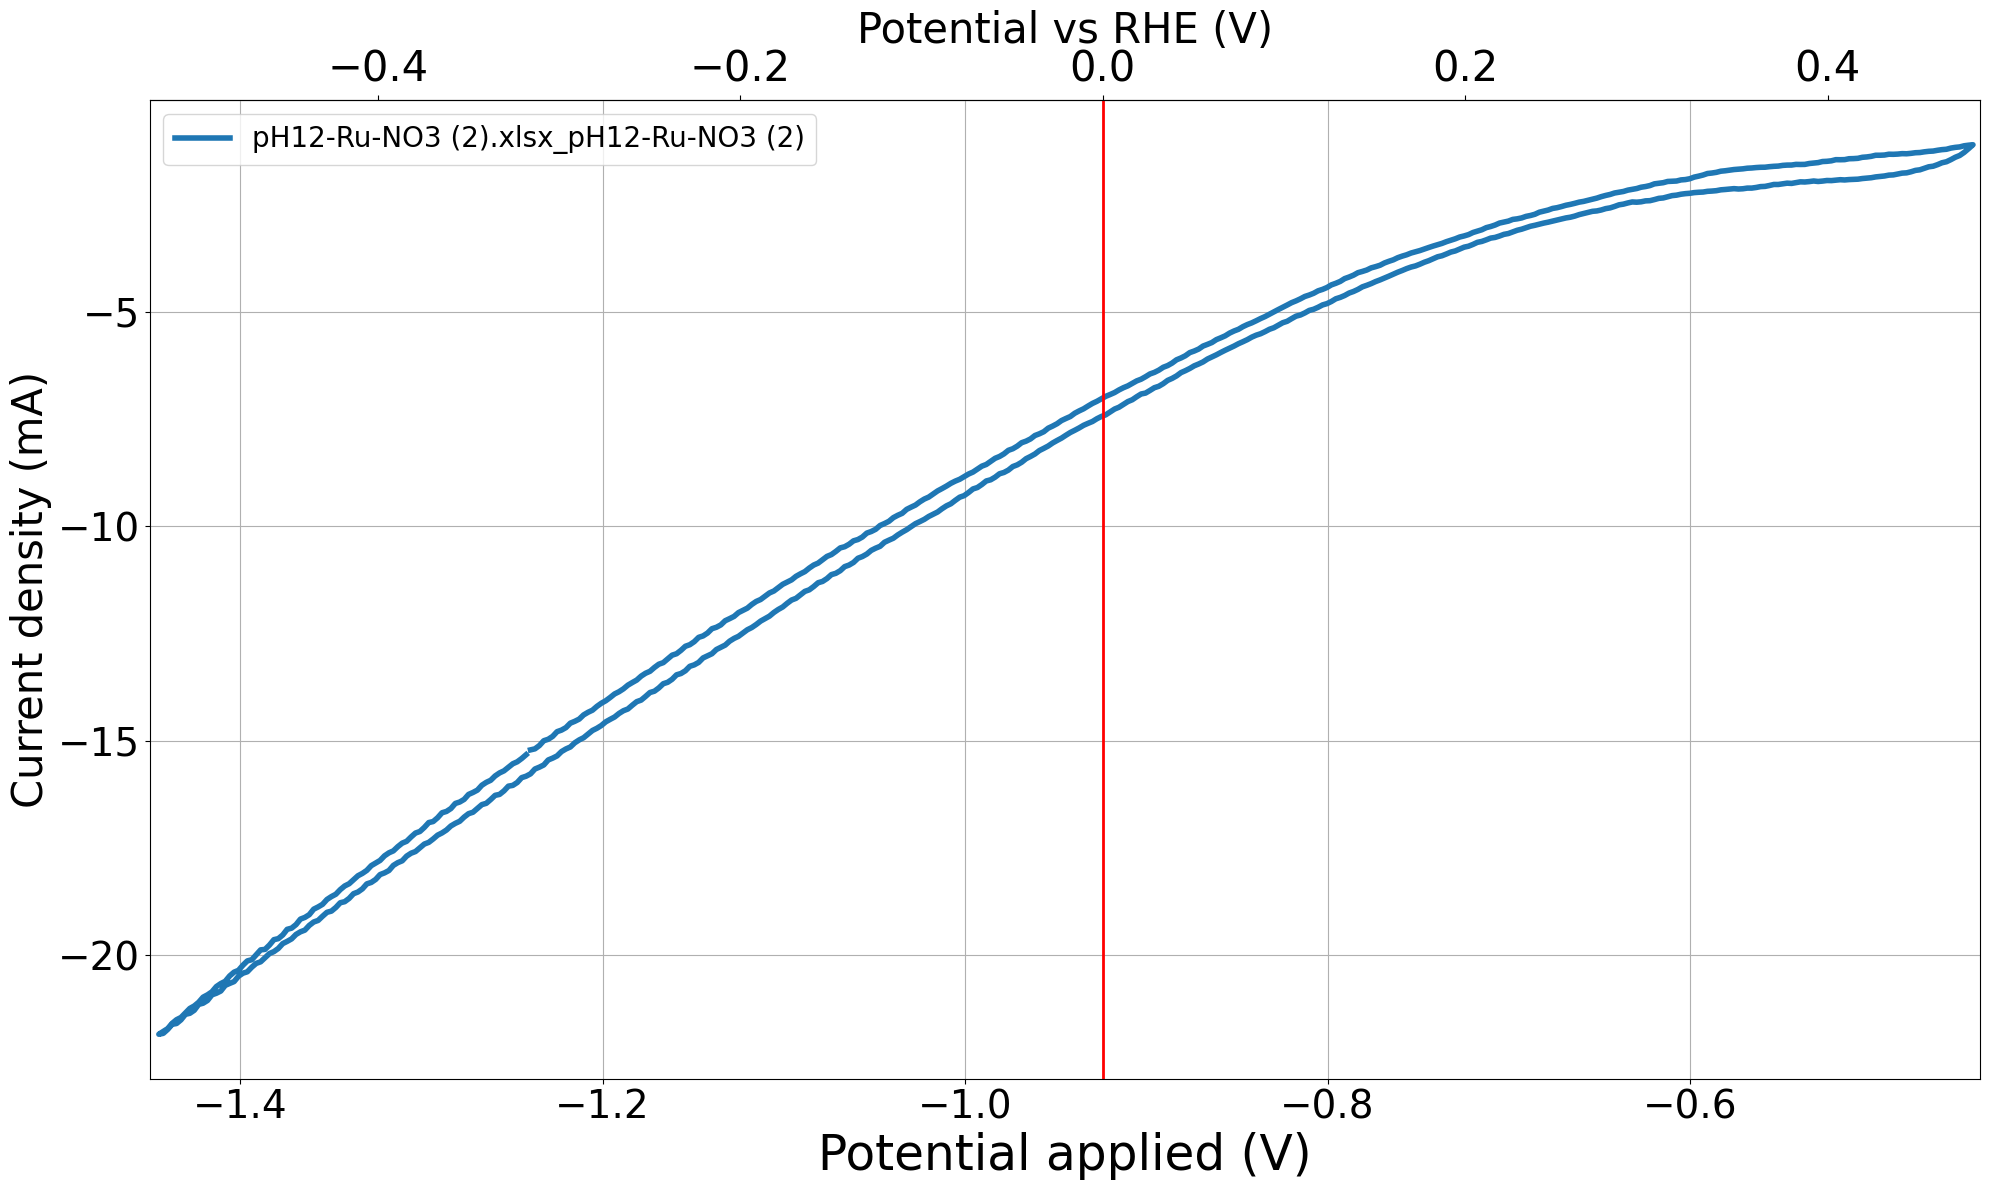

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display

# Function to handle legend name extraction based on file path
def get_legend_name(file_path):
    file_name = file_path.split('/')[-1]
    parts = file_name.split('_')
    return f"{parts[0]}_{parts[-1].split('.')[0]}"

# Function to handle file uploads in Google Colab
def upload_files():
    from google.colab import files
    uploaded = files.upload()
    file_paths = list(uploaded.keys())
    return file_paths

def plot_multiple_cyclovoltammograms():
    # Prompt user to select files for upload
    print("Please upload your Excel files (select multiple files if needed).")
    file_paths = upload_files()

    if not file_paths:
        print("No files selected.")
        return

    # Initialize plot
    fig, ax = plt.subplots(figsize=(20, 12))

    # Iterate through each uploaded file
    for file_path in file_paths:
        try:
            # Load data from the uploaded file
            data = pd.read_excel(file_path)

            # Prompt user to enter the scan number for this file
            scan_number = input(f"Enter the scan number to plot for {get_legend_name(file_path)}: ")

            # Filter data by the specified scan number
            data_filtered = data[data['Scan'] == int(scan_number)]

            if data_filtered.empty:
                print(f"No data found for scan number {scan_number} in file {file_path}.")
                continue

            # Extract voltage and current columns based on headers
            voltage = data_filtered['Potential applied (V)']
            current = data_filtered['WE(1).Current (A)']

            # Get legend label based on file name
            legend_label = get_legend_name(file_path)

            # Plot data with unique color for each file
            ax.plot(voltage, current * 1000, lw=4, label=legend_label)

        except Exception as e:
            print(f"Error reading {file_path} or plotting data: {e}")

    # Set plot titles and labels
    ax.set_xlabel('Potential applied (V)', fontsize=35)
    ax.set_ylabel('Current density (mA)', fontsize=30)
    ax.tick_params(axis='x', labelsize=28)
    ax.tick_params(axis='y', labelsize=28)
    ax.set_xlim(-1.45, -0.44)

    # Secondary x-axis with +0.924 offset
    def rhe_conversion(x):
        return x + 0.924

    secax = ax.secondary_xaxis('top', functions=(rhe_conversion, lambda x: x - 0.924))
    secax.set_xlabel('Potential vs RHE (V)', fontsize=30)
    secax.tick_params(axis='x', labelsize=30)

    # Add vertical red line at x=-0.924 on main axis
    ax.axvline(x=-0.924, color='red', lw=2)

    # Add legend and grid
    ax.legend(loc='best', fontsize=20)
    ax.grid(True)

    # Display plot
    plt.tight_layout()
    plt.show()

# Run the plot function
plot_multiple_cyclovoltammograms()
